In [129]:
import random
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime as dt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder

pd.set_option("display.max_colwidth",999)
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)
np.set_printoptions(suppress=True)


In [130]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [131]:
def plot_roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list
    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''
    
    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()

In [ ]:

# rf_model = pickle.load(open('rf_model' + str(i) +'.p', 'rb'))
# rf_model.predict_proba(X_test)



# Load data

In [3]:
# df_sf_2017 = pickle.load(open('../data_sf_2017.p', 'rb'))

In [132]:
df_sf_2017 = pd.read_json('df_sf_2017')
df_sf_2017.loc[df_sf_2017.cancellation_policy == 'flexible_new', 'cancellation_policy'] = "flexible"
prop_type = set(df_sf_2017.property_type.values)
keep = ['Apartment', 'House', 'Condomonium']
drop = list(set(prop_type).difference(keep))
df_sf_2017['property_type_new'] = df_sf_2017['property_type']
df_sf_2017.loc[df_sf_2017.property_type.isin(drop), 'property_type_new'] = "Other"


df_sf_2017['amenities_count'] = (df_sf_2017.amenities.apply(lambda x: len(x.split(','))))
df_sf_2017.is_business_travel_ready.fillna(value='f', inplace=True)

df_sf_2017.security_deposit.fillna(value='$0.00', inplace=True)
df_sf_2017['security_deposit'].replace('[\$,]', '', regex=True, inplace=True)
df_sf_2017['security_deposit'] = df_sf_2017.security_deposit.astype(float) 

df_sf_2017.description.fillna(value='None', inplace=True)
df_sf_2017["description_new"] = df_sf_2017['description'].str.replace('[^\w\s]','')

In [133]:
def transform_dummify(X, columns_to_keep):
    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

#     print(list(df_temp.columns.values))
    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)
    return df_temp

In [134]:
len(df_sf_2017)

117107

In [135]:
def split_num_data(start_month, end_month):
    X_test = df_sf_2017[df_sf_2017['month'] == end_month][columns_to_keep]
    y_test = df_sf_2017[df_sf_2017['month'] == end_month]['popular']
    return X_test, y_test

In [136]:
def split_str_data(start_month, end_month):
    df_X_train = df_sf_2017[(df_sf_2017['month'] >= start_month) & (df_sf_2017['month'] < end_month)]['description_new']
    df_X_test = df_sf_2017[df_sf_2017['month'] == end_month]['description_new']
    return df_X_train, df_X_test

In [137]:
def run_tf_idf_vec(df_X_train, df_X_test):
    tf_idf_vectorizer_train = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')
    X_train = tf_idf_vectorizer_train.fit_transform(df_X_train).toarray()
    tf_idf_vectorizer_test = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', vocabulary = tf_idf_vectorizer_train.vocabulary_)
    X_test = tf_idf_vectorizer_test.fit_transform(df_X_test).toarray()
    return X_test

## TRY WITH RANDOM FOREST 

In [81]:
%%time

start_month = 1
end_month = 4
model_num = 0
scores_ensemble = np.zeros(shape=(4,9))

columns_to_keep = ['host_length', 'amenities_count', 'review_scores_rating', 'host_response_rate', 'access_filled', 'house_rules_filled','space_filled','accommodates', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled', 'cancellation_policy', 'room_type', 'property_type_new', 'instant_bookable', 'calculated_host_listings_count', 'minimum_nights']

while end_month <13:
    X_test_num, y_test = split_num_data(start_month, end_month)
    X_test_num = transform_dummify(X_test_num, columns_to_keep)

    y_test = pd.DataFrame(np.array(y_test), columns=['y'])

    rf_num_model = pickle.load(open('rf_model' + str(model_num) +'.p', 'rb'))
#     rf_num_model = pickle.load(open('rf_model1.p', 'rb'))
    rf_num_pred_prob = rf_num_model.predict_proba(X_test_num)

    rf_num_output = pd.DataFrame(rf_num_pred_prob, columns=["RFnum - 0", "RFnum - 1"])
    rf_num_output.drop("RFnum - 0", axis=1, inplace=True)

    df_X_train, df_X_test = split_str_data(start_month, end_month)
    X_test_str = run_tf_idf_vec(df_X_train, df_X_test)

    rf_str_model = pickle.load(open('tf_idf_rf_descrip' + str(model_num) +'.p', 'rb')) 
#     rf_str_model = pickle.load(open('tf_idf_rf_descrip0.p', 'rb')) 
    rf_str_pred_prob = rf_str_model.predict_proba(X_test_str)

    rf_str_output = pd.DataFrame(rf_str_pred_prob, columns=["RFstr - 0", "RFstr - 1"])
    rf_str_output.drop("RFstr - 0", axis=1, inplace=True)
    
    print(start_month, end_month, model_num)
        
    df_final = pd.concat([rf_num_output, rf_str_output], axis=1) 
    df_final['average'] = (df_final['RFnum - 1'] + df_final["RFstr - 1"])/2
    df_final_combo = pd.concat([df_final, y_test], axis =1)
    
    # concatenate models and the actual result so that we can do a random split for the decision tree test
    df_final_combo.loc[df_final_combo.average > 0.5,'combined_proba'] = True
    df_final_combo.loc[df_final_combo.average <= 0.5,'combined_proba'] = False

    scores_ensemble[0][model_num] = accuracy_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[1][model_num] = recall_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[2][model_num] = precision_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[3][model_num] = f1_score(df_final_combo.combined_proba, df_final_combo.y)
    
    print(scores_ensemble)
    
    model_num += 1
    start_month += 1
    end_month += 1


1 4 0
[[0.96259639 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.94768311 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.8325673  0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88640336 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
2 5 1
[[0.96259639 0.96284404 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.94768311 0.97176471 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.8325673  0.81139489 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88640336 0.88436831 0.         0.         0.         0.
  0.         0.         0.        ]]
3 6 2
[[0.96259639 0.96284404 0.95820997 0.         0.         0.
  0.         0.         0.        ]
 [0.94768311 0.97176471 0.95851852 0.         0.         0.
  0.         0.         0.        ]
 [0.8325673  0.81139

In [83]:
accuracy_2017 = np.mean(scores_ensemble_ensemble[0])
recall_2017 = np.mean(scores_ensemble[1])
precision_2017 = np.mean(scores_ensemble[2])
f1_score_2017 = np.mean(scores_ensemble[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)

0.9566544297164883
0.955096658142044
0.8232753470921405
0.8839164063978197


## TRY WITH XGBOOST

In [85]:
%%time

start_month = 1
end_month = 4
model_num = 0
scores_ensemble = np.zeros(shape=(4,9))

columns_to_keep = ['host_length', 'amenities_count', 'review_scores_rating', 'host_response_rate', 'access_filled', 'house_rules_filled','space_filled','accommodates', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled', 'cancellation_policy', 'room_type', 'property_type_new', 'instant_bookable', 'calculated_host_listings_count', 'minimum_nights']

while end_month <13:
    X_test_num, y_test = split_num_data(start_month, end_month)
    X_test_num = transform_dummify(X_test_num, columns_to_keep)

    y_test = pd.DataFrame(np.array(y_test), columns=['y'])

    xgboost_num_model = pickle.load(open('xgboost_model' + str(model_num) +'.p', 'rb'))
#     rf_num_model = pickle.load(open('rf_model1.p', 'rb'))
    xgboost_num_pred_prob = xgboost_num_model.predict_proba(X_test_num)

    xgboost_num_output = pd.DataFrame(xgboost_num_pred_prob, columns=["xgboostnum - 0", "xgboostnum - 1"])
    xgboost_num_output.drop("xgboostnum - 0", axis=1, inplace=True)

    df_X_train, df_X_test = split_str_data(start_month, end_month)
    X_test_str = run_tf_idf_vec(df_X_train, df_X_test)

    rf_str_model = pickle.load(open('tf_idf_rf_descrip' + str(model_num) +'.p', 'rb')) 
#     rf_str_model = pickle.load(open('tf_idf_rf_descrip0.p', 'rb')) 
    rf_str_pred_prob = rf_str_model.predict_proba(X_test_str)

    rf_str_output = pd.DataFrame(rf_str_pred_prob, columns=["RFstr - 0", "RFstr - 1"])
    rf_str_output.drop("RFstr - 0", axis=1, inplace=True)
    
    print(start_month, end_month, model_num)
        
    df_final = pd.concat([xgboost_num_output, rf_str_output], axis=1) 
    df_final['average'] = (df_final['xgboostnum - 1'] + df_final["RFstr - 1"])/2
    df_final_combo = pd.concat([df_final, y_test], axis =1)
    
    # concatenate models and the actual result so that we can do a random split for the decision tree test
    df_final_combo.loc[df_final_combo.average > 0.5,'combined_proba'] = True
    df_final_combo.loc[df_final_combo.average <= 0.5,'combined_proba'] = False

    scores_ensemble[0][model_num] = accuracy_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[1][model_num] = recall_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[2][model_num] = precision_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[3][model_num] = f1_score(df_final_combo.combined_proba, df_final_combo.y)
    
    print(scores_ensemble)
    
    probabilities = np.array(df_final_combo['average'])
    labels = np.array(df_final_combo['y'])
    tprs1, fprs1, thresholds = plot_roc_curve(probabilities, labels)
    plt.plot(fprs, tprs, label = "model" + str(model_num))  

    model_num += 1
    start_month += 1
    end_month += 1


1 4 0
[[0.96524341 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.92602931 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87130663 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.89783491 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
2 5 1
[[0.96524341 0.96536697 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.92602931 0.94937638 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87130663 0.84741323 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.89783491 0.89550173 0.         0.         0.         0.
  0.         0.         0.        ]]
3 6 2
[[0.96524341 0.96536697 0.96253701 0.         0.         0.
  0.         0.         0.        ]
 [0.92602931 0.94937638 0.94060773 0.         0.         0.
  0.         0.         0.        ]
 [0.87130663 0.84741

In [88]:
accuracy_2017 = np.mean(scores_ensemble[0])
recall_2017 = np.mean(scores_ensemble[1])
precision_2017 = np.mean(scores_ensemble[2])
f1_score_2017 = np.mean(scores_ensemble[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)

0.9597373783644562
0.9353666781153473
0.8595175297972932
0.8955666296791621


1 4 0
[[0.96524341 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.92602931 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87130663 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.89783491 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
2 5 1
[[0.96524341 0.96536697 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.92602931 0.94937638 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87130663 0.84741323 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.89783491 0.89550173 0.         0.         0.         0.
  0.         0.         0.        ]]
3 6 2
[[0.96524341 0.96536697 0.96253701 0.         0.         0.
  0.         0.         0.        ]
 [0.92602931 0.94937638 0.94060773 0.         0.         0.
  0.         0.         0.        ]
 [0.87130663 0.84741

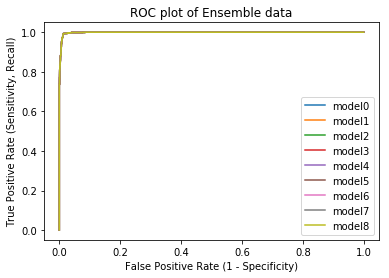

CPU times: user 8min 14s, sys: 23.3 s, total: 8min 37s
Wall time: 9min 11s


In [143]:
%%time

start_month = 1
end_month = 4
model_num = 0
scores_ensemble = np.zeros(shape=(4,9))

columns_to_keep = ['host_length', 'amenities_count', 'review_scores_rating', 'host_response_rate', 'access_filled', 'house_rules_filled','space_filled','accommodates', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled', 'cancellation_policy', 'room_type', 'property_type_new', 'instant_bookable', 'calculated_host_listings_count', 'minimum_nights']

while end_month <13:
    X_test_num, y_test = split_num_data(start_month, end_month)
    X_test_num = transform_dummify(X_test_num, columns_to_keep)

    y_test = pd.DataFrame(np.array(y_test), columns=['y'])

    xgboost_num_model = pickle.load(open('xgboost_model' + str(model_num) +'.p', 'rb'))
    xgboost_num_pred_prob = xgboost_num_model.predict_proba(X_test_num)

    xgboost_num_output = pd.DataFrame(xgboost_num_pred_prob, columns=["xgboostnum - 0", "xgboostnum - 1"])
    xgboost_num_output.drop("xgboostnum - 0", axis=1, inplace=True)

    df_X_train, df_X_test = split_str_data(start_month, end_month)
    X_test_str = run_tf_idf_vec(df_X_train, df_X_test)

    rf_str_model = pickle.load(open('tf_idf_rf_descrip' + str(model_num) +'.p', 'rb')) 
    rf_str_pred_prob = rf_str_model.predict_proba(X_test_str)

    rf_str_output = pd.DataFrame(rf_str_pred_prob, columns=["RFstr - 0", "RFstr - 1"])
    rf_str_output.drop("RFstr - 0", axis=1, inplace=True)
    
    print(start_month, end_month, model_num)
        
    df_final = pd.concat([xgboost_num_output, rf_str_output], axis=1) 
    df_final['average'] = (df_final['xgboostnum - 1'] + df_final["RFstr - 1"])/2
    df_final_combo = pd.concat([df_final, y_test], axis =1)
    
    # concatenate models and the actual result so that we can do a random split for the decision tree test
    df_final_combo.loc[df_final_combo.average > 0.5,'combined_proba'] = True
    df_final_combo.loc[df_final_combo.average <= 0.5,'combined_proba'] = False

    scores_ensemble[0][model_num] = accuracy_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[1][model_num] = recall_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[2][model_num] = precision_score(df_final_combo.combined_proba, df_final_combo.y)
    scores_ensemble[3][model_num] = f1_score(df_final_combo.combined_proba, df_final_combo.y)
    
    print(scores_ensemble)
    
    probabilities = np.array(df_final_combo['average'])
    labels = np.array(df_final_combo['y'])
    tprs1, fprs1, thresholds = plot_roc_curve(probabilities, labels)
    plt.plot(fprs, tprs, label = "model" + str(model_num))  
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    plt.title("ROC plot of Ensemble data")
    plt.legend()
    
    model_num += 1
    start_month += 1
    end_month += 1

plt.show()

In [ ]:
probabilities = np.array(df_final_combo['average'])
labels = np.array(df_final_combo['y'])
tprs1, fprs1, thresholds = plot_roc_curve(probabilities, labels)
plt.plot(fprs, tprs, label = "model" + str(model_num))  

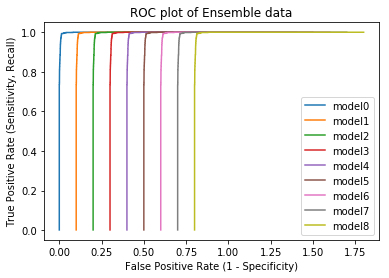

In [142]:
start_month = 1
end_month = 4
model_num = 0

while end_month <13:
    probabilities = np.array(df_final_combo['average'])
    labels = np.array(df_final_combo['y'])
    tprs1, fprs1, thresholds = plot_roc_curve(probabilities, labels)
    plt.plot(np.array(fprs)+0.1*model_num, tprs, label = "model" + str(model_num))  
    
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    plt.title("ROC plot of Ensemble data")
    plt.legend()
    
    
    model_num += 1
    start_month += 1
    end_month += 1

plt.show()

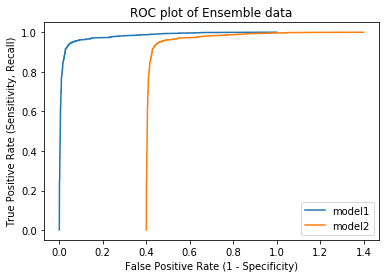

In [128]:
probabilities1 = np.array(df_final_combo['average'])
labels1 = np.array(df_final_combo['y'])
tprs1, fprs1, thresholds1 = plot_roc_curve(probabilities1, labels1)
plt.plot(fprs1, tprs1, label = "model1")  


probabilities2 = np.array(df_final_combo['average'])
labels2 = np.array(df_final_combo['y'])
tprs2, fprs2, thresholds2 = plot_roc_curve(probabilities2, labels2)
plt.plot(np.array(fprs2)+0.4, tprs2, label = "model2") 


plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of Ensemble data")
plt.legend()
plt.show()

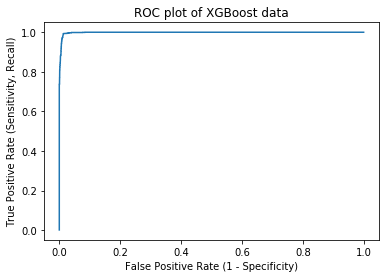

In [72]:
probabilities1 = np.array(df_final_combo['average'])
labels1 = np.array(df_final_combo['y'])
tprs1, fprs1, thresholds1 = plot_roc_curve(probabilities, labels)
plt.plot(fprs1, tprs1)  
probabilities2 = np.array(df_final_combo['average']-.5)
labels2 = np.array(df_final_combo['y'])
tprs2, fprs2, thresholds2 = plot_roc_curve(probabilities, labels)
plt.plot(fprs2, tprs2)  
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of Ensemble data")
plt.legend()
plt.show()

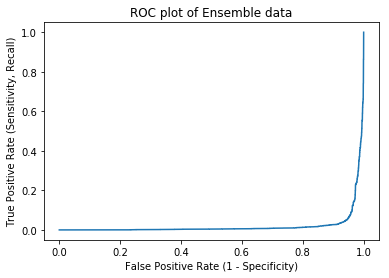

In [90]:
tpr, fpr, thresholds = roc_curve( np.array(df_final_combo['y']) , np.array(df_final_combo['average']), pos_label= 1)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of Ensemble data")
plt.show()

In [91]:
tpr, fpr, thresholds = roc_curve(np.array(df_final_combo['average']),np.array(df_final_combo['y']) ,  pos_label= 1)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of Ensemble data")
plt.show()

ValueError: continuous format is not supported

# NLP

In [139]:
import nltk
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import time
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [140]:
df_sf_2017.description.fillna(value='None', inplace=True)

In [141]:
df_sf_2017["description_new"] = df_sf_2017['description'].str.replace('[^\w\s]','')

## DESCRIPTION COLUMN MODEL

In [142]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [143]:
# def split_data(start_month, end_month):
start_month = 1
end_month = 4

df_X_train_nlp = df_sf_2017[(df_sf_2017['month'] >= start_month) & (df_sf_2017['month'] < end_month)]['description_new']
y_train_nlp = df_sf_2017[(df_sf_2017['month'] >= start_month) & (df_sf_2017['month'] < end_month)]['popular']

df_X_test_nlp = df_sf_2017[df_sf_2017['month'] == end_month]['description_new']
y_test_nlp = df_sf_2017[df_sf_2017['month'] == end_month]['popular']

# return df_X_train, y_train, df_X_test, y_test

## Run CountVectorizer

In [144]:
def run_tf_vec(df_X_train, df_X_test):
    tf_vectorizer_train = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english').fit(df_X_train)
    X_train = tf_vectorizer_train.transform(df_X_train)
    tf_vectorizer_test = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', vocabulary = tf_vectorizer_train.vocabulary_).fit(df_X_test)
    X_test = tf_vectorizer_test.transform(df_X_test)
    return X_train, X_test, tf_vectorizer_train

In [145]:
X_train_nlp, X_test_nlp, tf_vectorizer_train = run_tf_vec(df_X_train_nlp, df_X_test_nlp)

In [146]:
model_probs_tf_nlp = np.zeros(shape=(9,X_test_nb.shape[0])) 

model_num = 0

from sklearn.ensemble import RandomForestClassifier
nlp = RandomForestClassifier(n_estimators = 50, n_jobs=-1, random_state=0, class_weight = {0:.95, 1:.05})
nlp.fit(X_train_nb, y_train_nb)
pred_prob_nb = nlp.predict_proba(X_test_nb)


In [147]:
nlp_output = pd.DataFrame(pred_prob_nb, columns=["NLP - 0", "NLP - 1"])
nlp_output.drop("NLP - 0", axis=1, inplace=True)

In [92]:
# b_model = pd.DataFrame(np.array([[5,6],[7,8]]))
# pd.concat([a,b], axis=1)

In [148]:
y = pd.DataFrame(np.array(y_test_nlp), columns=['y'])

In [150]:
columns_to_keep = ['accommodates','bed_type', 'extra_people', 'price_per_guest','guests_included', 'host_about_filled','host_picture_url_filled', 'cancellation_policy', 'room_type', 'property_type_new']

df_sf_2017.loc[df_sf_2017.cancellation_policy == 'flexible_new', 'cancellation_policy'] = "flexible"
prop_type = set(df_sf_2017.property_type.values)
keep = ['Apartment', 'House', 'Condomonium']
drop = list(set(prop_type).difference(keep))
df_sf_2017['property_type_new'] = df_sf_2017['property_type']
df_sf_2017.loc[df_sf_2017.property_type.isin(drop), 'property_type_new'] = "Other"


X_train_rf = df_sf_2017[(df_sf_2017['month'] >= start_month) & (df_sf_2017['month'] < end_month)][columns_to_keep]
y_train_rf = df_sf_2017[(df_sf_2017['month'] >= start_month) & (df_sf_2017['month'] < end_month)]['popular']

X_test_rf = df_sf_2017[df_sf_2017['month'] == end_month][columns_to_keep]
y_test_rf = df_sf_2017[df_sf_2017['month'] == end_month]['popular']



In [203]:
def transform_dummify(X, columns_to_keep):
    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

#     print(list(df_temp.columns.values))
    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)
    return df_temp

In [205]:
X_train_rf = transform_dummify(X_train_rf, columns_to_keep)
X_test_rf = transform_dummify(X_test_rf, columns_to_keep)

In [153]:
from xgboost import XGBClassifier

In [154]:
def transform_boost(X, columns_to_keep):
    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

#     print(list(df_temp.columns.values))
    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)
    return df_temp

In [155]:
X_train_xgb = transform_boost(X_train_rf, columns_to_keep)

In [156]:
X_test_xgb = transform_boost(X_test_rf, columns_to_keep)

In [157]:
%%time
my_model = XGBClassifier(n_jobs=-1, booster='gbtree', n_estimators=1000, learning_rate=1, objective='binary:logistic')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 27.7 µs


In [158]:
%%time
my_model.fit(X_train_xgb, y_train_rf, verbose=False)

CPU times: user 11.6 s, sys: 408 ms, total: 12 s
Wall time: 1.52 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [159]:
xgb_pred_prob = my_model.predict_proba(X_test_xgb)

In [160]:
xgb_output = pd.DataFrame(xgb_pred_prob, columns=["XGB - 0", "XGB - 1"])
xgb_output.drop("XGB - 0", axis=1, inplace=True)

## ADA BOOST

In [102]:
from sklearn.ensemble import AdaBoostClassifier #For Classification

In [103]:
# dt = DecisionTreeClassifier() 
# clf = AdaBoostClassifier(n_estimators=500, base_estimator=dt,learning_rate=1)
# #Above I have used decision tree as a base estimator, you can use any ML learner as base estimator if it ac# cepts sample weight 
# clf.fit(X_train_rf,y_train_rf)
# adaboost_pred_prob = clf.predict_proba(X_test_rf)

In [104]:
# adaboost_output = pd.DataFrame(adaboost_pred_prob, columns=["AB - 0", "AB - 1"])
# adaboost_output.drop("AB - 0", axis=1, inplace=True)

## RF

In [92]:
# rf = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=0, max_depth= 2, max_features= 'auto', class_weight = {0:.95, 1:.05})
# rf.fit(X_train_rf, y_train_rf)

# pred_prob_rf = rf.predict_proba(X_test_rf)

In [93]:
# rf_output = pd.DataFrame(pred_prob_rf, columns=["RF - 0", "RF - 1"])
# rf_output.drop("RF - 0", axis=1, inplace=True)

In [161]:
df_final = pd.concat([nlp_output, xgb_output], axis=1) #concatenate models and the actual result so that we can do a random split for the decision tree test
df_final['average'] = (df_final['NLP - 1'] + df_final["XGB - 1"])/2
df_final_combo = pd.concat([df_final, y], axis =1)
df_final_combo.loc[df_final_combo.average > 0.5,'combined_proba'] = True
df_final_combo.loc[df_final_combo.average <= 0.5,'combined_proba'] = False
df_final_combo

,NLP - 1,XGB - 1,average,y,combined_proba
0,0.020000,8.331098e-02,5.165549e-02,False,False
1,0.000000,2.783990e-01,1.391995e-01,False,False
2,0.000000,7.475761e-02,3.737880e-02,False,False
3,0.000000,5.479729e-02,2.739864e-02,False,False
4,0.000000,7.497721e-04,3.748861e-04,False,False
5,0.020000,1.229868e-04,1.006149e-02,False,False
6,0.000000,4.564612e-02,2.282306e-02,False,False
7,0.000000,5.148936e-03,2.574468e-03,False,False
8,0.000000,7.857411e-06,3.928706e-06,False,False
9,0.720000,5.414966e-01,6.307483e-01,True,True


In [177]:
len(np.array(df_final_combo['y']))

8689

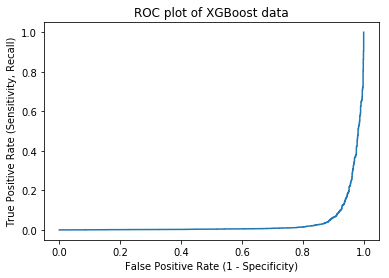

In [198]:
tpr, fpr, thresholds = roc_curve(np.array(df_final_combo['y']), np.array(df_final_combo['average']), pos_label= 1)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of XGBoost data")
plt.show()

## XG Boost

In [129]:
print(accuracy_score(df_final_combo.combined_proba, df_final_combo.y))
print(recall_score(df_final_combo.combined_proba, df_final_combo.y))
print(precision_score(df_final_combo.combined_proba, df_final_combo.y))
print(f1_score(df_final_combo.combined_proba, df_final_combo.y))

0.9499367015767062
0.9377372817008353
0.7777078085642317
0.8502581755593804


## adaboost

In [106]:
print(accuracy_score(df_final_combo.combined_proba, df_final_combo.y))
print(recall_score(df_final_combo.combined_proba, df_final_combo.y))
print(precision_score(df_final_combo.combined_proba, df_final_combo.y))
print(f1_score(df_final_combo.combined_proba, df_final_combo.y))

0.9577626884566693
0.9485672299779574
0.8129722921914357
0.8755510342488979


## random forest

In [96]:
print(accuracy_score(df_final_combo.combined_proba, df_final_combo.y))
print(recall_score(df_final_combo.combined_proba, df_final_combo.y))
print(precision_score(df_final_combo.combined_proba, df_final_combo.y))
print(f1_score(df_final_combo.combined_proba, df_final_combo.y))

0.845321671078375
0.9728682170542635
0.1580604534005038
0.27193932827735645


In [130]:
df_final_combo.drop('average', axis=1, inplace=True)

In [131]:
from sklearn.tree import DecisionTreeClassifier

In [132]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(df_final, y, test_size=0.3, random_state=423)

dt = DecisionTreeClassifier(random_state=11, class_weight = {0:.95, 1:.05}, max_features = 'auto', min_samples_split = 2)

## XG BOOST

In [133]:
dt.fit(X_train_final, y_train_final)
preds_final = dt.predict(X_test_final)
print(accuracy_score(y_test_final, preds_final))
print(recall_score(y_test_final, preds_final))
print(precision_score(y_test_final, preds_final))
print(f1_score(y_test_final, preds_final))

0.9409282700421941
0.841648590021692
0.8272921108742004
0.8344086021505376


## adaboost

In [111]:
dt.fit(X_train_final, y_train_final)
preds_final = dt.predict(X_test_final)
print(accuracy_score(y_test_final, preds_final))
print(recall_score(y_test_final, preds_final))
print(precision_score(y_test_final, preds_final))
print(f1_score(y_test_final, preds_final))


0.9359416954353663
0.8004338394793926
0.831081081081081
0.8154696132596684


## random forest

In [100]:
dt.fit(X_train_final, y_train_final)
preds_final = dt.predict(X_test_final)
print(accuracy_score(y_test_final, preds_final))
print(recall_score(y_test_final, preds_final))
print(precision_score(y_test_final, preds_final))
print(f1_score(y_test_final, preds_final))


0.9439969313387034
0.8199566160520607
0.8571428571428571
0.8381374722838137


## COUNT VECTORIZER NAIVE BAYES ORIGINAL

In [15]:
accuracy_2017_tf_nb = np.mean(scores_tf_nb[0])
recall_2017_tf_nb = np.mean(scores_tf_nb[1])
precision_2017_tf_nb = np.mean(scores_tf_nb[2])
f1_score_2017_tf_nb = np.mean(scores_tf_nb[3])
print(accuracy_2017_tf_nb)
print(recall_2017_tf_nb)
print(precision_2017_tf_nb)
print(f1_score_2017_tf_nb)

0.8742970560045102
0.7169107075713074
0.6929862495075171
0.7043799660889926


## COUNT VECTORIZER RANDOM FOREST ORIGINAL

In [14]:
accuracy_2017_tf_rf = np.mean(scores_tf_rf[0])
recall_2017_tf_rf = np.mean(scores_tf_rf[1])
precision_2017_tf_rf = np.mean(scores_tf_rf[2])
f1_score_2017_tf_rf = np.mean(scores_tf_rf[3])
print(accuracy_2017_tf_rf)
print(recall_2017_tf_rf)
print(precision_2017_tf_rf)
print(f1_score_2017_tf_rf)

0.9474790730435897
0.790758536328864
0.9494687554573628
0.8623895527424829


## Try running with TF-IDF

In [237]:
def run_tf_idf_vec(df_X_train, df_X_test):
    tf_idf_vectorizer_train = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')
    X_train2 = tf_idf_vectorizer_train.fit_transform(df_X_train).toarray()
    tf_idf_vectorizer_test = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', vocabulary = tf_vectorizer_train.vocabulary_)
    X_test2 = tf_idf_vectorizer_test.fit_transform(df_X_test).toarray()
    return X_train2, X_test2, tf_idf_vectorizer_train

In [76]:
def predict_tf_idf_nb(X_train2, y_train, X_test2, y_test):
    from sklearn.naive_bayes import GaussianNB
    nb = GaussianNB()
    nb.fit(X_train2, y_train)
    # pickle.dump(nb, open('nb_model_guassian.p', 'wb'))
    preds = nb.predict(X_test2)
    scores_tf_idf_nb[0][model_num] = accuracy_score(y_test, preds)
    scores_tf_idf_nb[1][model_num] = recall_score(y_test, preds)
    scores_tf_idf_nb[2][model_num] = precision_score(y_test, preds)
    scores_tf_idf_nb[3][model_num] = f1_score(y_test, preds)
    return scores_tf_idf_nb

## With the TF-IDF, run with RandomForest 

In [77]:
def predict_tf_idf_rf(X_train2, y_train, X_test2, y_test):
    rf = RandomForestClassifier(n_estimators = 10, n_jobs=-1, random_state=0, class_weight = {0:.95, 1:.05})
    rf.fit(X_train2, y_train)
    predicted = rf.predict(X_test2)
#     pickle.dump(rf, open('rf_nlp_50.p', 'wb'))
    scores_tf_idf_rf[0][model_num] = accuracy_score(y_test, predicted)
    scores_tf_idf_rf[1][model_num] = recall_score(y_test, predicted)
    scores_tf_idf_rf[2][model_num] = precision_score(y_test, predicted)
    scores_tf_idf_rf[3][model_num] = f1_score(y_test, predicted)
    return scores_tf_idf_rf

In [78]:
scores_tf_idf_nb = np.zeros(shape=(4,9))
scores_tf_idf_rf = np.zeros(shape=(4,9))

model_num = 0
start_month = 1
end_month = 4

In [79]:
%%time
while end_month <13:
    df_X_train, y_train, df_X_test, y_test = split_data(start_month, end_month) 
    X_train2, X_test2, tf_idf_vectorizer_train = run_tf_idf_vec(df_X_train, df_X_test)
    scores_tf_idf_nb = predict_tf_idf_nb(X_train2, y_train, X_test2, y_test)
    scores_tf_idf_rf = predict_tf_idf_rf(X_train2, y_train, X_test2, y_test)
    print(start_month, end_month, model_num)
    model_num += 1
    start_month += 1
    end_month += 1
    print('tf_idf_nb')
    print(scores_tf_idf_nb)
    print('tf_idf_rf')
    print(scores_tf_idf_rf)

1 4 0
tf_idf_nb
[[0.61328888 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.93702771 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.31313131 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.46940063 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
tf_idf_rf
[[0.94643062 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.76448363 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.9295559  0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.83897719 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
CPU times: user 6min 52s, sys: 3.94 s, total: 6min 56s
Wall time: 2min 24s


## TF IDF NAIVE BAYES ORIGINAL

In [30]:
accuracy_2017_tf_idf_nb = np.mean(scores_tf_idf_nb[0])
recall_2017_tf_idf_nb = np.mean(scores_tf_idf_nb[1])
precision_2017_tf_idf_nb = np.mean(scores_tf_idf_nb[2])
f1_score_2017_tf_idf_nb = np.mean(scores_tf_idf_nb[3])
print(accuracy_2017_tf_idf_nb)
print(recall_2017_tf_idf_nb)
print(precision_2017_tf_idf_nb)
print(f1_score_2017_tf_idf_nb)

0.6223984688066541
0.9360869500755025
0.3467272958014258
0.5052056786500755
